# The modified surface code
Compilation time will cause a delay for most calculations here for their first run, especially plots and
operator weight calculations.

In [1]:
using Logging, Statistics
using Qecsim, Qecsim.GenericModels
using TensorNetworkCodes, TensorNetworkCodes.QecsimAdaptors, TensorNetworkCodes.TNDistance

┌ Info: Precompiling TensorNetworkCodes [b317c587-d840-4e81-9857-9d906192e215]
└ @ Base loading.jl:1342


## Let's change one of the seed codes in the rotated surface code
We'll only change the central seed code

In [2]:
stabilizers = [[3, 3, 0, 0, 3], [0, 3, 2, 3, 0], [2, 2, 0, 1, 0], [0, 2, 1, 0, 2]]
logicals = [[3, 0, 0, 3, 0], [2, 0, 0, 0, 2]]
new_seed_code = SimpleCode("Altered five qubit surface code", stabilizers, logicals)

# Let's define our new code
modified_rotated_surface_code(L) = almost_rotated_surface_code(L, new_seed_code, fill(ceil(Int,L/2), 2));

## Let's find the stabilizers for a 7x7 code
Most of them are the same as for the rotated surface code

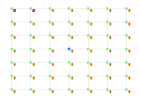

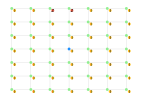

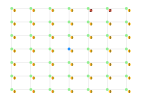

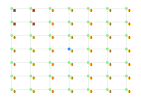

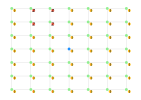

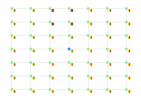

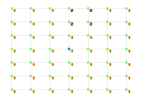

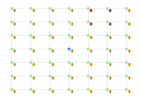

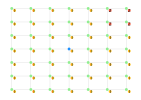

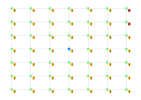

In [3]:
L = 7
□ = modified_rotated_surface_code(L)
operators = □.stabilizers

for η in 1:10 # just some operators, for all use: 1:length(operators)
    display(plot_operator(□, operators[η]))
end

## Let's find the three weird stabilizers
We simplify them by taking products with local stabilizers

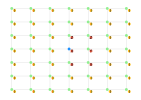

In [6]:
# This one needs to be multiplied by one other stabilizers to simplify
plot_operator(□,pauli_product(operators[[20,28]]))

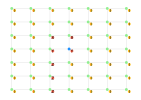

In [7]:
# This next one needs to be multiplied by three stabilizers to simplify
plot_operator(□, pauli_product(operators[[46, 45, 44, 42]]))

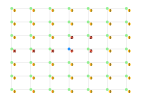

In [11]:
# Third one
plot_operator(□, pauli_product(operators[[20, 11, 18]]))

## Let's look at the code distances

In [21]:
□_weights = tn_operator_weights(□)
□_dist = □_weights.distance

surface = rotated_surface_code(L)
surface_weights = tn_operator_weights(surface)
surface_dist = surface_weights.distance

println("Modified code distance is $(□_dist).")
println("Rotated surface code distance is $(surface_dist).")

Modified code distance is 7.
Rotated surface code distance is 7.


## Degeneracy of the min-weight logical operators

In [18]:
□_deg = □_weights.all_operator_weights[□_dist+1] - □_weights.stabilizer_weights[□_dist+1]
println("Degeneracy of min-weight logical operators for modified code is $(□_deg).")

surface_deg = surface_weights.all_operator_weights[surface_dist+1] - 
surface_weights.stabilizer_weights[surface_dist+1]
println("For the rotated surface code it is $(surface_deg).")

Degeneracy of min-weight logical operators for modified code is 662.
For the rotated surface code it is 896.


## Compare error correction properties with the normal rotated surface code
* This uses exact TN contraction to decode to get a fair comparison between the codes.

* Here we look at depolarizing noise.

* Current parameters below take about one minute on my laptop. (i7-7500U CPU @ 2.70GHz × 4, 8GB RAM)

In [19]:
ℓ = 5
qs_surf_code = QecsimTNCode(rotated_surface_code(ℓ); distance=5, label="5x5 Surface Code")
qs_mod_code = QecsimTNCode(modified_rotated_surface_code(ℓ); distance=5, label="5x5 Modified Code")

function eval_success_probabilities(code1, code2, error_probabilities, max_runs, seed=11)
    error_model, decoder = DepolarizingErrorModel(), QecsimTNDecoder()
    # success data [code1, code2]
    empirical = [(rates=[], stderrs=[]), (rates=[], stderrs=[])]
    predicted = [(rates=[], stderrs=[]), (rates=[], stderrs=[])]
    with_logger(NullLogger()) do  # disable qecsim logs
        for p in error_probabilities
            p_seed = trunc(Int, seed * p * 1000)  # different seed for each p
            for (i, code) in enumerate((code1, code2))
                # run simulation
                data = qec_run(code, error_model, decoder, p, p_seed; max_runs=max_runs)
                # process data
                esr = data[:n_success]/data[:n_run]  # empirical success rate
                push!(empirical[i].rates, esr)
                push!(empirical[i].stderrs, sqrt(esr*(1-esr)/data[:n_run]))
                psr = mean(data[:custom_totals][1])  # predicted success rate
                push!(predicted[i].rates, psr)
                push!(predicted[i].stderrs, stdm(data[:custom_totals][1], psr) / sqrt(data[:n_run]))
                print('.')  # progress indicator
            end
        end
        println()
    end
    return (empirical=empirical, predicted=predicted)
end

error_probabilities = [0.0,0.02,0.04,0.06,0.08,0.10,0.12,0.14,0.16,0.18,0.2]
num_iter = 1000
@time output = eval_success_probabilities(qs_surf_code, qs_mod_code, error_probabilities, num_iter);

......................
 70.370153 seconds (270.31 M allocations: 78.904 GiB, 10.59% gc time, 28.66% compilation time)


## Let's plot this

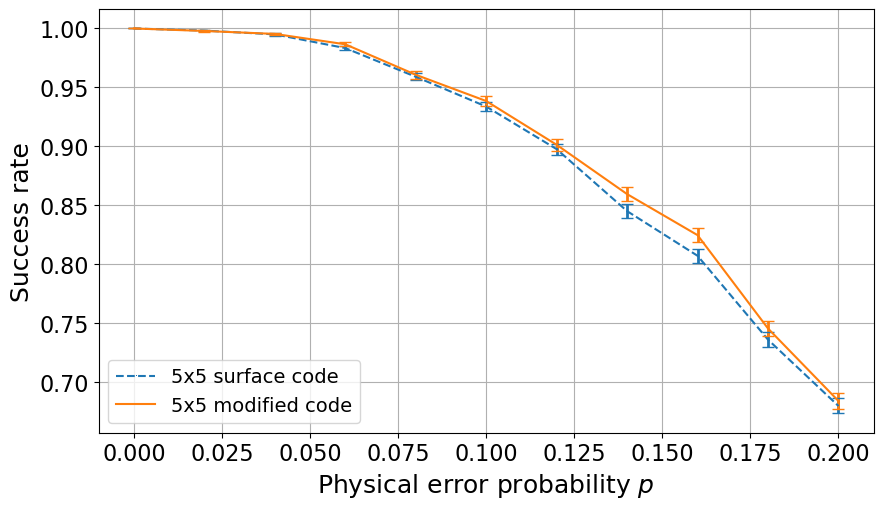

In [20]:
success_data = output.predicted  # change to output.empirical for empirical plot

using PyPlot
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
font0 = Dict(
    "font.size" => 16,
    "axes.labelweight" => "normal",
    "axes.labelsize" => 18,
    "xtick.labelsize" => 16,
    "ytick.labelsize" => 16,
    "legend.fontsize" => 14,
)
merge!(rcParams, font0)

x = error_probabilities
fig, ax = subplots(figsize=(10,5.5))

y = success_data[1].rates
yerr = [success_data[1].stderrs, success_data[1].stderrs]
p = ax.plot(x,y,linestyle="dashed",marker=",",color="C0",label="$(ℓ)x$(ℓ) surface code")
pe = ax.errorbar(x,y,yerr,color="C0",fmt=",",markersize=7, capsize=4, elinewidth=2)

y = success_data[2].rates
yerr = [success_data[2].stderrs, success_data[2].stderrs]
p = ax.plot(x,y,linestyle="solid",marker=",",color="C1",label="$(ℓ)x$(ℓ) modified code")
pe = ax.errorbar(x,y,yerr,color="C1",fmt=",",markersize=7, capsize=4, elinewidth=2)

ax.axis("tight")
ax.set_xlabel("Physical error probability \$p\$",fontsize=18)
ax.set_ylabel("Success rate",fontsize=18)
ax.grid(true)
legend(loc="lower left");
# plt.savefig("name.pdf", bbox_inches="tight", pad_inches=0.1)